# Import Libraries

In [100]:
import requests
import json
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
import seaborn as sns
import matplotlib.cm as cm
import umap.umap_ as umap

from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import DBSCAN, KMeans
from sklearn.metrics.pairwise import cosine_distances, cosine_similarity
from sklearn.metrics import silhouette_score, davies_bouldin_score

from sentence_transformers import SentenceTransformer

# Data Loading

In [2]:
df = pd.read_json('yugioh_cards.json')

# Exploratory Data Analysis

In [3]:
df.head(5)

,id,name,type,humanReadableCardType,frameType,desc,race,archetype,ygoprodeck_url,card_sets,...,atk,def,level,attribute,linkval,linkmarkers,pend_desc,monster_desc,scale,banlist_info
0,34541863,"""A"" Cell Breeding Device",Spell Card,Continuous Spell,spell,"During each of your Standby Phases, put 1 A-Co...",Continuous,Alien,https://ygoprodeck.com/card/a-cell-breeding-de...,"[{'set_name': 'Force of the Breaker', 'set_cod...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,64163367,"""A"" Cell Incubator",Spell Card,Continuous Spell,spell,Each time an A-Counter(s) is removed from play...,Continuous,Alien,https://ygoprodeck.com/card/a-cell-incubator-8856,"[{'set_name': 'Gladiator's Assault', 'set_code...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,91231901,"""A"" Cell Recombination Device",Spell Card,Quick-Play Spell,spell,Target 1 face-up monster on the field; send 1 ...,Quick-Play,Alien,https://ygoprodeck.com/card/a-cell-recombinati...,"[{'set_name': 'Invasion: Vengeance', 'set_code...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,73262676,"""A"" Cell Scatter Burst",Spell Card,Quick-Play Spell,spell,"Select 1 face-up ""Alien"" monster you control. ...",Quick-Play,Alien,https://ygoprodeck.com/card/a-cell-scatter-bur...,"[{'set_name': 'Strike of Neos', 'set_code': 'S...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,98319530,"""Infernoble Arms - Almace""",Spell Card,Equip Spell,spell,While this card is equipped to a monster: You ...,Equip,Infernoble Arms,https://ygoprodeck.com/card/infernoble-arms-al...,"[{'set_name': 'Duelist Nexus', 'set_code': 'DU...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13567 entries, 0 to 13566
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     13567 non-null  int64  
 1   name                   13567 non-null  object 
 2   type                   13567 non-null  object 
 3   humanReadableCardType  13567 non-null  object 
 4   frameType              13567 non-null  object 
 5   desc                   13567 non-null  object 
 6   race                   13567 non-null  object 
 7   archetype              8043 non-null   object 
 8   ygoprodeck_url         13567 non-null  object 
 9   card_sets              13097 non-null  object 
 10  card_images            13567 non-null  object 
 11  card_prices            13567 non-null  object 
 12  typeline               8712 non-null   object 
 13  atk                    8712 non-null   float64
 14  def                    8286 non-null   float64
 15  le

In [5]:
df2 = df[['id','name','frameType','desc','race']]

In [6]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13567 entries, 0 to 13566
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         13567 non-null  int64 
 1   name       13567 non-null  object
 2   frameType  13567 non-null  object
 3   desc       13567 non-null  object
 4   race       13567 non-null  object
dtypes: int64(1), object(4)
memory usage: 530.1+ KB


In [7]:
df2.head()

,id,name,frameType,desc,race
0,34541863,"""A"" Cell Breeding Device",spell,"During each of your Standby Phases, put 1 A-Co...",Continuous
1,64163367,"""A"" Cell Incubator",spell,Each time an A-Counter(s) is removed from play...,Continuous
2,91231901,"""A"" Cell Recombination Device",spell,Target 1 face-up monster on the field; send 1 ...,Quick-Play
3,73262676,"""A"" Cell Scatter Burst",spell,"Select 1 face-up ""Alien"" monster you control. ...",Quick-Play
4,98319530,"""Infernoble Arms - Almace""",spell,While this card is equipped to a monster: You ...,Equip


In [8]:
df2 = df2.iloc[:, [0,1,2,4,3]]

In [9]:
df2.head()

,id,name,frameType,race,desc
0,34541863,"""A"" Cell Breeding Device",spell,Continuous,"During each of your Standby Phases, put 1 A-Co..."
1,64163367,"""A"" Cell Incubator",spell,Continuous,Each time an A-Counter(s) is removed from play...
2,91231901,"""A"" Cell Recombination Device",spell,Quick-Play,Target 1 face-up monster on the field; send 1 ...
3,73262676,"""A"" Cell Scatter Burst",spell,Quick-Play,"Select 1 face-up ""Alien"" monster you control. ..."
4,98319530,"""Infernoble Arms - Almace""",spell,Equip,While this card is equipped to a monster: You ...


In [10]:
df2.isna().sum()

id           0
name         0
frameType    0
race         0
desc         0
dtype: int64

In [11]:
df2.drop_duplicates()

,id,name,frameType,race,desc
0,34541863,"""A"" Cell Breeding Device",spell,Continuous,"During each of your Standby Phases, put 1 A-Co..."
1,64163367,"""A"" Cell Incubator",spell,Continuous,Each time an A-Counter(s) is removed from play...
2,91231901,"""A"" Cell Recombination Device",spell,Quick-Play,Target 1 face-up monster on the field; send 1 ...
3,73262676,"""A"" Cell Scatter Burst",spell,Quick-Play,"Select 1 face-up ""Alien"" monster you control. ..."
4,98319530,"""Infernoble Arms - Almace""",spell,Equip,While this card is equipped to a monster: You ...
...,...,...,...,...,...
13562,2648201,ZW - Sleipnir Mail,effect,Beast,"You can target 1 ""Utopia"" monster you control;..."
13563,95886782,ZW - Sylphid Wing,effect,Beast,"You can only control 1 ""ZW - Sylphid Wing"". Yo..."
13564,81471108,ZW - Tornado Bringer,effect,Dragon,"You can target 1 ""Utopia"" monster you control;..."
13565,18865703,ZW - Ultimate Shield,effect,Aqua,When this card is Normal or Special Summoned: ...


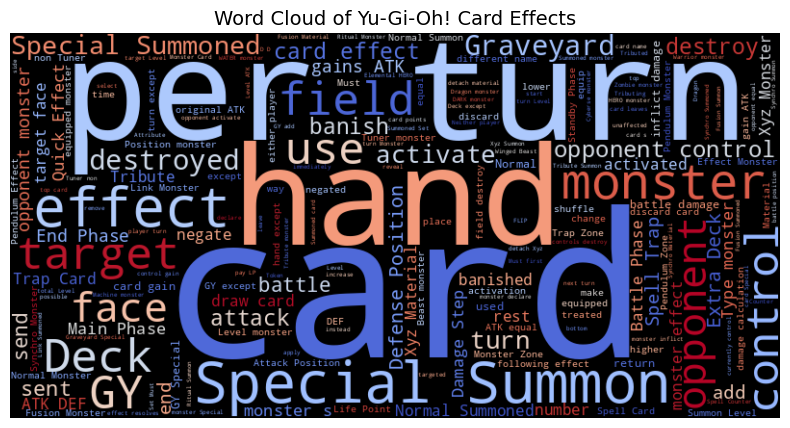

In [12]:
text_data = " ".join(df2['desc'].astype(str))

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='black', colormap='coolwarm',
                      max_words=200, contour_color='white').generate(text_data)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")  # Hide axes
plt.title("Word Cloud of Yu-Gi-Oh! Card Effects", fontsize=14)
plt.show()

In [13]:
# Aggregate count of each frameType
frame_counts = df2['frameType'].value_counts().reset_index()
frame_counts.columns = ['frameType', 'count']  # Rename columns for clarity

# Create Pie Chart
fig = px.pie(
    frame_counts,  
    names='frameType',  # Categories
    values='count',  # Use the counts for the segment sizes
    title='Distribution of Frame Types'
)

fig.show()

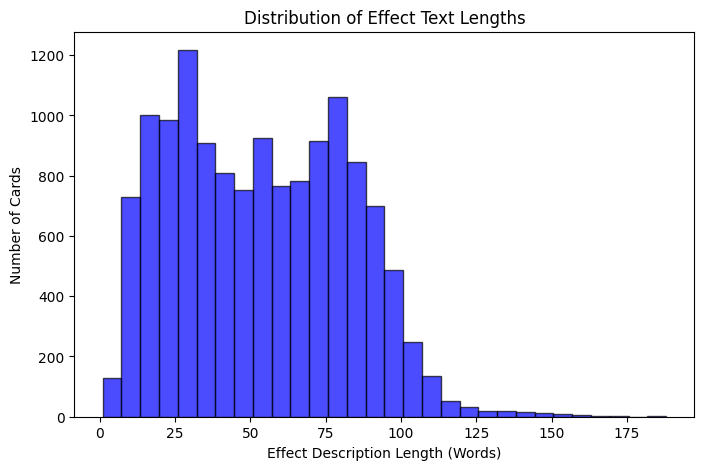

In [14]:
df2["desc_length"] = df2["desc"].apply(lambda x: len(str(x).split()))

# Plot distribution
plt.figure(figsize=(8,5))
plt.hist(df2["desc_length"], bins=30, color='blue', edgecolor='black', alpha=0.7)
plt.xlabel("Effect Description Length (Words)")
plt.ylabel("Number of Cards")
plt.title("Distribution of Effect Text Lengths")
plt.show()

# Feature Engineering

In [15]:
df2 = df2[df2['frameType']!='normal'].reset_index(drop=True)

Since the normal monster always part of the core deck, they also don't have effects I don't think they need to be categorized.

In [38]:
custom_stopwords = set([
    "card", "monster", "effect", "field", "turn", "hand", "use", "control",
    "opponent", "deck", "graveyard", "gy", "position", "activated", "banish", "summoned", "your",
    "controls", "control", "summon", "spell", "trap", "and", "monsters", "cards", "a", 'pendulum',
    'non', 'per', 'face', 'up', 'down', 's'
])

In [39]:
# Function to clean text and remove stopwords
def Clean_RemoveStopword(text, stopwords_set):
    # Convert to lowercase
    text = text.lower()
    # Remove special characters and punctuation
    text = re.sub(r'\W+', ' ', text)
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    # Remove stopwords
    text = " ".join([word for word in text.split() if word not in stopwords_set])
    return text

In [40]:
df2['clean_desc'] = df2['desc'].apply(lambda x: Clean_RemoveStopword(x, custom_stopwords))
df2[['desc', 'clean_desc']].head()

,desc,clean_desc
0,"During each of your Standby Phases, put 1 A-Co...",during each of standby phases put 1 counter on 1
1,Each time an A-Counter(s) is removed from play...,each time an counter is removed from play by p...
2,Target 1 face-up monster on the field; send 1 ...,target 1 on the send 1 alien from to the if yo...
3,"Select 1 face-up ""Alien"" monster you control. ...",select 1 alien you destroy it distribute new c...
4,While this card is equipped to a monster: You ...,while this is equipped to you can equip 1 infe...


## Making Tokens by Splitting it using Space

In [41]:
df2['tokens'] = df2['clean_desc'].apply(lambda x: x.split())

In [42]:
df2[['tokens','clean_desc']].head()

,tokens,clean_desc
0,"[during, each, of, standby, phases, put, 1, co...",during each of standby phases put 1 counter on 1
1,"[each, time, an, counter, is, removed, from, p...",each time an counter is removed from play by p...
2,"[target, 1, on, the, send, 1, alien, from, to,...",target 1 on the send 1 alien from to the if yo...
3,"[select, 1, alien, you, destroy, it, distribut...",select 1 alien you destroy it distribute new c...
4,"[while, this, is, equipped, to, you, can, equi...",while this is equipped to you can equip 1 infe...


## Creating Vectors

In [43]:
# # Initialize the TF-IDF vectorizer
# tfidf_vectorizer = TfidfVectorizer(max_features=5000)  # Limit to 5000 most important words

# # Transform the cleaned descriptions into TF-IDF features
# tfidf_matrix = tfidf_vectorizer.fit_transform(df2['clean_desc'])

# # Convert the TF-IDF matrix into a DataFrame for better visualization
# tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())


In [44]:
# tfidf_df.head()

# Model Creation

## SBERT

In [45]:
# Load SBERT model
sbert_model = SentenceTransformer('all-MiniLM-L6-v2')

# Convert card descriptions into embeddings
sentence_embeddings = sbert_model.encode(df2['clean_desc'], show_progress_bar=True)

# Convert embeddings to a NumPy array
sentence_embeddings = np.array(sentence_embeddings)

# Check embedding shape
print(sentence_embeddings.shape)

Batches:   0%|          | 0/403 [00:00<?, ?it/s]

(12890, 384)


## Use KMeans

In [142]:
num_clusters = 7

kmeans = KMeans(n_clusters=num_clusters, random_state=26, n_init=10)
cluster_labels = kmeans.fit_predict(sentence_embeddings)

df2["cluster"] = cluster_labels

df2["cluster"].value_counts()

cluster
4    2749
2    2633
5    2631
3    1724
0    1330
6    1197
1     626
Name: count, dtype: int64

## Cosine Similarity

In [143]:
# Compute cosine similarity between cards and cluster centroids
cluster_centroids = kmeans.cluster_centers_
similarities = cosine_similarity(sentence_embeddings, cluster_centroids)

# Set a threshold (e.g., 0.5) for multi-label assignment
threshold = 0.61
multi_labels = [[i for i, sim in enumerate(sim) if sim > threshold] for sim in similarities]

# Store multi-labels in the dataframe
df2['multi_labels'] = multi_labels

In [144]:
df2[df2['name']=='Ash Blossom & Joyous Spring']

,id,name,frameType,race,desc,desc_length,clean_desc,tokens,cluster,multi_labels
698,14558127,Ash Blossom & Joyous Spring,effect,Zombie,When a card or effect is activated that includ...,64,when or is that includes any of these effects ...,"[when, or, is, that, includes, any, of, these,...",2,[]


In [145]:
df2[df2['name']=='Effect Veiler']

,id,name,frameType,race,desc,desc_length,clean_desc,tokens,cluster,multi_labels
3426,97268402,Effect Veiler,effect,Spellcaster,During your opponent's Main Phase (Quick Effec...,42,during main phase quick you can send this from...,"[during, main, phase, quick, you, can, send, t...",4,"[4, 5]"


In [146]:
df2[df2['name']=='Lava Golem']

,id,name,frameType,race,desc,desc_length,clean_desc,tokens,cluster,multi_labels
6246,102380,Lava Golem,effect,Fiend,Cannot be Normal Summoned/Set. Must first be S...,43,cannot be normal set must first be special fro...,"[cannot, be, normal, set, must, first, be, spe...",2,[]


In [147]:
df2[df2['name']=='The Winged Dragon of Ra - Sphere Mode']

,id,name,frameType,race,desc,desc_length,clean_desc,tokens,cluster,multi_labels
11378,10000080,The Winged Dragon of Ra - Sphere Mode,effect,Divine-Beast,Cannot be Special Summoned. Requires 3 Tribute...,85,cannot be special requires 3 tributes from eit...,"[cannot, be, special, requires, 3, tributes, f...",2,"[2, 6]"


In [148]:
df2[df2['name']=='Thunder King, the Lightningstrike Kaiju']

,id,name,frameType,race,desc,desc_length,clean_desc,tokens,cluster,multi_labels
11444,48770333,"Thunder King, the Lightningstrike Kaiju",effect,Thunder,You can Special Summon this card (from your ha...,96,you can special this from to side of the in at...,"[you, can, special, this, from, to, side, of, ...",5,"[2, 5, 6]"


In [149]:
df2[df2['name']=="Raigeki"]

,id,name,frameType,race,desc,desc_length,clean_desc,tokens,cluster,multi_labels
9014,12580477,Raigeki,spell,Normal,Destroy all monsters your opponent controls.,6,destroy all,"[destroy, all]",5,[]


In [150]:
df2[df2['name']=="Lightning Storm"]

,id,name,frameType,race,desc,desc_length,clean_desc,tokens,cluster,multi_labels
6389,14532163,Lightning Storm,spell,Normal,If you control no face-up cards: Activate 1 of...,38,if you no activate 1 of these effects destroy ...,"[if, you, no, activate, 1, of, these, effects,...",4,[]


In [151]:
df2[df2['name']=="Harpie's Feather Duster"]

,id,name,frameType,race,desc,desc_length,clean_desc,tokens,cluster,multi_labels
5249,18144507,Harpie's Feather Duster,spell,Normal,Destroy all Spell and Trap Cards your opponent...,9,destroy all,"[destroy, all]",5,[]


In [156]:
df2[df2['name']=="Reinforcement of the Army"]

,id,name,frameType,race,desc,desc_length,clean_desc,tokens,cluster,multi_labels
9222,32807846,Reinforcement of the Army,spell,Normal,Add 1 Level 4 or lower Warrior monster from yo...,14,add 1 level 4 or lower warrior from to,"[add, 1, level, 4, or, lower, warrior, from, to]",2,[]


In [157]:
df2[df2['name']=="Shien's Smoke Signal"]

,id,name,frameType,race,desc,desc_length,clean_desc,tokens,cluster,multi_labels
9932,54031490,Shien's Smoke Signal,spell,Normal,"Add 1 Level 3 or lower ""Six Samurai"" monster f...",15,add 1 level 3 or lower six samurai from to,"[add, 1, level, 3, or, lower, six, samurai, fr...",2,[]


In [152]:
raigeki_emb = sentence_embeddings[df2[df2['name'] == 'Raigeki'].index[0]].reshape(1, -1)
storm_emb = sentence_embeddings[df2[df2['name'] == 'Lightning Storm'].index[0]].reshape(1, -1)
harpie_emb = sentence_embeddings[df2[df2['name'] == "Harpie's Feather Duster"].index[0]].reshape(1, -1)

similarity_raigeki_harpie = cosine_similarity(raigeki_emb, harpie_emb)[0][0]
similarity_storm_harpie = cosine_similarity(storm_emb, harpie_emb)[0][0]

print(f"Cosine Similarity (Raigeki <-> Harpie's Feather Duster): {similarity_raigeki_harpie}")
print(f"Cosine Similarity (Lightning Storm <-> Harpie's Feather Duster): {similarity_storm_harpie}")

Cosine Similarity (Raigeki <-> Harpie's Feather Duster): 1.000000238418579
Cosine Similarity (Lightning Storm <-> Harpie's Feather Duster): 0.3668330907821655


In [153]:
sil_score = silhouette_score(sentence_embeddings, df2['cluster'])
db_score = davies_bouldin_score(sentence_embeddings, df2['cluster'])

print(f"Silhouette Score: {sil_score}")
print(f"Davies-Bouldin Index: {db_score}")

Silhouette Score: 0.036469679325819016
Davies-Bouldin Index: 4.291124906597115


## Semi-Unsupervised

In [158]:
# Define known labels
known_labels = {
    "Raigeki": "board-breaker",
    "Harpie's Feather Duster": "board-breaker",
    "Lightning Storm": "board-breaker",
    
    "Ash Blossom & Joyous Spring": "hand-traps",
    "Effect Veiler": "hand-traps",
    "Droll & Lock Bird": "hand-traps",
    
    "Reinforcement of the Army": "searcher",
    "Shien's Smoke Signal": "searcher",
}

# Initialize a column for categories
df2['category'] = df2['name'].map(known_labels).fillna("unknown")  # Assign known categories, others remain 'unknown'


In [159]:
# Set number of clusters (adjust based on expected groups)
num_clusters = 7  # Since you identified 7 categories

# Apply KMeans clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=26)
df2['cluster'] = kmeans.fit_predict(sentence_embeddings)

In [ ]:
# Group by cluster to see which cards ended up together
df2.groupby("cluster")['name'].apply(list)

cluster
0    ["A" Cell Breeding Device, "A" Cell Incubator,...
1    ["Infernoble Arms - Almace", "Infernoble Arms ...
2    [7 Completed, A Hero Lives, A Legendary Ocean,...
3    [Accel Synchro Stardust Dragon, Accel Synchron...
4    [1st Movement Solo, A Deal with Dark Ruler, A ...
5    [A Bao A Qu, the Lightless Shadow, A Man with ...
6    [4-Starred Ladybug of Doom, A Wingbeat of Gian...
Name: name, dtype: object

In [162]:
# Create a mapping for cluster IDs → categories
cluster_names = {
    df2[df2['category'] == "board-breaker"]['cluster'].mode()[0]: "board-breaker",
    df2[df2['category'] == "hand-traps"]['cluster'].mode()[0]: "hand-traps",
    df2[df2['category'] == "searcher"]['cluster'].mode()[0]: "searcher",
}

# Assign final category names
df2['final_category'] = df2['cluster'].map(cluster_names).fillna("unknown")

In [163]:
df2[['name', 'clean_desc', 'final_category']]

,name,clean_desc,final_category
0,"""A"" Cell Breeding Device",during each of standby phases put 1 counter on 1,searcher
1,"""A"" Cell Incubator",each time an counter is removed from play by p...,searcher
2,"""A"" Cell Recombination Device",target 1 on the send 1 alien from to the if yo...,searcher
3,"""A"" Cell Scatter Burst",select 1 alien you destroy it distribute new c...,searcher
4,"""Infernoble Arms - Almace""",while this is equipped to you can equip 1 infe...,board-breaker
...,...,...,...
12885,ZW - Sleipnir Mail,you can target 1 utopia you equip this from or...,unknown
12886,ZW - Sylphid Wing,you can only 1 zw sylphid wing you can target ...,unknown
12887,ZW - Tornado Bringer,you can target 1 utopia you equip this from or...,unknown
12888,ZW - Ultimate Shield,when this is normal or special you can target ...,unknown


## A bit Manual

In [ ]:
# Compute pairwise cosine similarity for all SBERT embeddings
cosine_sim_matrix = cosine_similarity(sentence_embeddings)

# Convert to DataFrame for readability
sim_df = pd.DataFrame(cosine_sim_matrix, index=df2['name'], columns=df2['name'])

# Show similarity between some cards
sim_df.loc[['Raigeki', 'Harpie\'s Feather Duster', 'Lightning Storm'], 
           ['Raigeki', 'Harpie\'s Feather Duster', 'Lightning Storm']]

name,Raigeki,Harpie's Feather Duster,Lightning Storm
name,,,
Raigeki,1.000000,1.000000,0.366833
Harpie's Feather Duster,1.000000,1.000000,0.366833
Lightning Storm,0.366833,0.366833,1.000000


In [193]:
# Define a similarity threshold (adjust based on results)
SIMILARITY_THRESHOLD = 0.75

# Create an empty dictionary to store card clusters
card_clusters = {}

# Loop through each card and find its most similar cards
for card in df2['name']:
    similar_cards = sim_df[card][sim_df[card] >= SIMILARITY_THRESHOLD].index.tolist()
    card_clusters[card] = ', '.join(similar_cards)  # Convert list to a string

# Convert dictionary to DataFrame
card_cluster_df = pd.DataFrame(list(card_clusters.items()), columns=['Card', 'Similar Cards'])

# Display the result
card_cluster_df.head()


,Card,Similar Cards
0,"""A"" Cell Breeding Device","""A"" Cell Breeding Device, Cloudian Squall"
1,"""A"" Cell Incubator","""A"" Cell Incubator, Magical Citadel of Endymio..."
2,"""A"" Cell Recombination Device","""A"" Cell Recombination Device, Alien Stealthbu..."
3,"""A"" Cell Scatter Burst","""A"" Cell Scatter Burst, Code A Ancient Ruins"
4,"""Infernoble Arms - Almace""","""Infernoble Arms - Almace"", ""Infernoble Arms -..."


In [194]:
card_name = "Raigeki"

# Check which cards were grouped with it
if card_name in card_clusters:
    print(f"Cards similar to {card_name}:")
    print(card_clusters[card_name])
else:
    print(f"{card_name} not found in clusters.")


Cards similar to Raigeki:
Dark Hole, Harpie's Feather Duster, Heavy Storm, Raigeki


In [182]:
# Extract embeddings for Ash Blossom, Effect Veiler, and Droll & Lock Bird
ash_emb = sentence_embeddings[df2[df2['name'] == 'Ash Blossom & Joyous Spring'].index[0]].reshape(1, -1)
veiler_emb = sentence_embeddings[df2[df2['name'] == 'Effect Veiler'].index[0]].reshape(1, -1)
droll_emb = sentence_embeddings[df2[df2['name'] == 'Droll & Lock Bird'].index[0]].reshape(1, -1)

# Compute Cosine Similarity
similarity_ash_veiler = cosine_similarity(ash_emb, veiler_emb)[0][0]
similarity_ash_droll = cosine_similarity(ash_emb, droll_emb)[0][0]
similarity_veiler_droll = cosine_similarity(veiler_emb, droll_emb)[0][0]

# Print Results
print(f"Cosine Similarity (Ash Blossom <-> Effect Veiler): {similarity_ash_veiler:.4f}")
print(f"Cosine Similarity (Ash Blossom <-> Droll & Lock Bird): {similarity_ash_droll:.4f}")
print(f"Cosine Similarity (Effect Veiler <-> Droll & Lock Bird): {similarity_veiler_droll:.4f}")

Cosine Similarity (Ash Blossom <-> Effect Veiler): 0.5981
Cosine Similarity (Ash Blossom <-> Droll & Lock Bird): 0.3197
Cosine Similarity (Effect Veiler <-> Droll & Lock Bird): 0.5182


In [183]:
for card in ['Ash Blossom & Joyous Spring', 'Effect Veiler', 'Droll & Lock Bird']:
    print(f"{card}: {df2[df2['name'] == card]['clean_desc'].values[0]}")

Ash Blossom & Joyous Spring: when or is that includes any of these effects quick you can discard this negate that add from the to the special from the send from the to the you can only this of ash blossom joyous spring once
Effect Veiler: during main phase quick you can send this from to the then target 1 negate the effects of that until the end of this
Droll & Lock Bird: if is added from the main to except during the draw phase quick you can send this from to the for the rest of this cannot be added from either player main to the


# Cluster Check

## Cluster 0

In [154]:
df2[df2['cluster']== 0].head()

,id,name,frameType,race,desc,desc_length,clean_desc,tokens,cluster,multi_labels
27,28596933,A Wingbeat of Giant Dragon,spell,Normal,Return 1 Level 5 or higher Dragon-Type monster...,26,return 1 level 5 or higher dragon type you to ...,"[return, 1, level, 5, or, higher, dragon, type...",0,[]
34,59332125,A.I. Love Fusion,spell,Normal,Fusion Summon 1 Cyberse Fusion Monster from yo...,51,fusion 1 cyberse fusion from extra using from ...,"[fusion, 1, cyberse, fusion, from, extra, usin...",0,[0]
53,71422989,Absorb Fusion,spell,Normal,"Add 1 ""Gem-Knight"" card from your Deck to your...",66,add 1 gem knight from to then you can apply th...,"[add, 1, gem, knight, from, to, then, you, can...",0,[0]
75,21044178,Abyss Dweller,xyz,Sea Serpent,2 Level 4 monsters\nWhile this card has a mate...,48,2 level 4 while this has material attached tha...,"[2, level, 4, while, this, has, material, atta...",0,[0]
102,9453320,"Abysstrite, the Atlantean Spirit",xyz,Sea Serpent,2+ Level 7 WATER monsters\r\nWATER monsters yo...,77,2 level 7 water water you gain 300 atk def for...,"[2, level, 7, water, water, you, gain, 300, at...",0,[0]


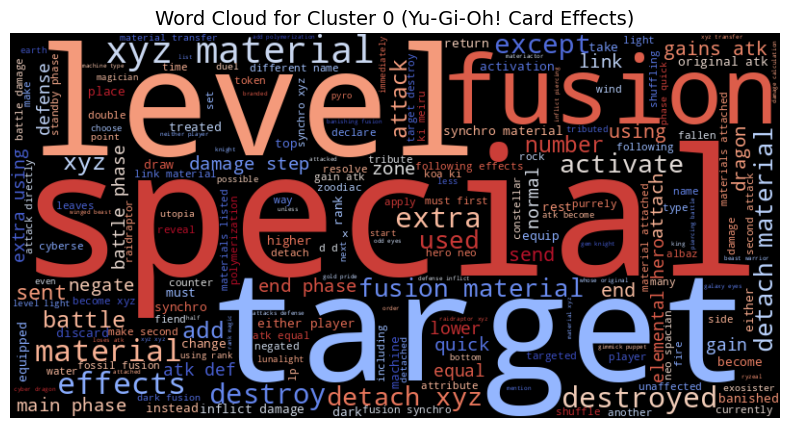

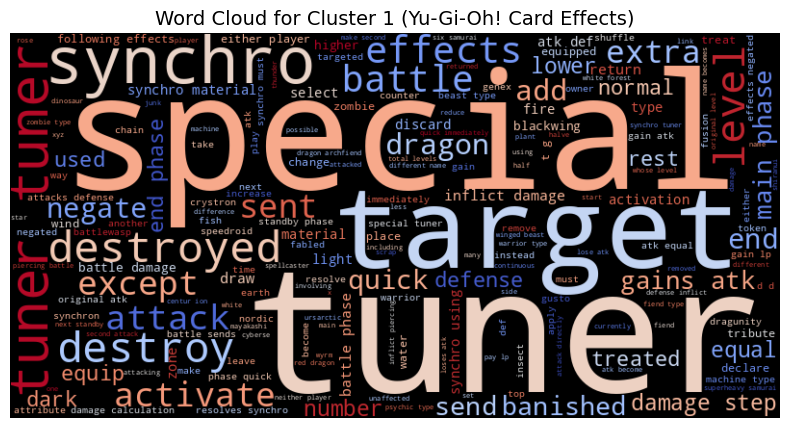

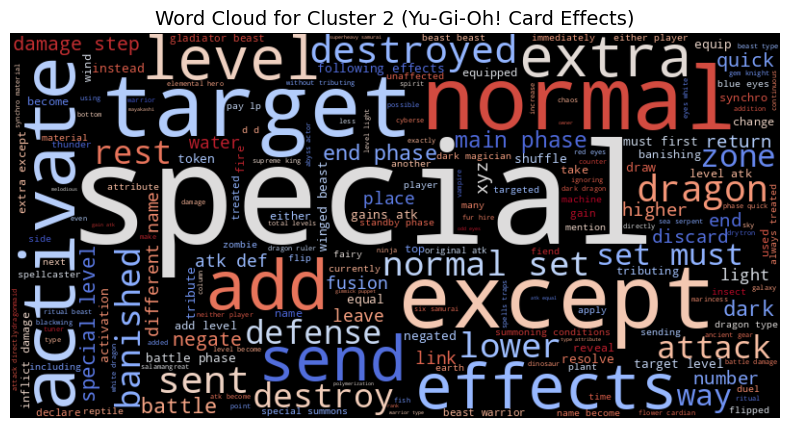

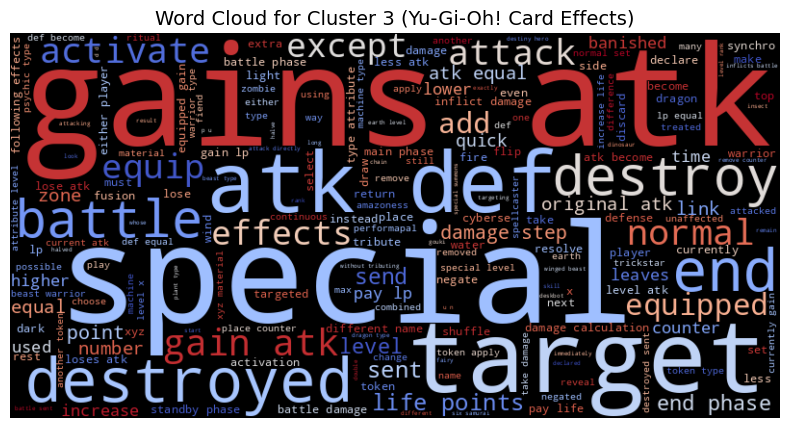

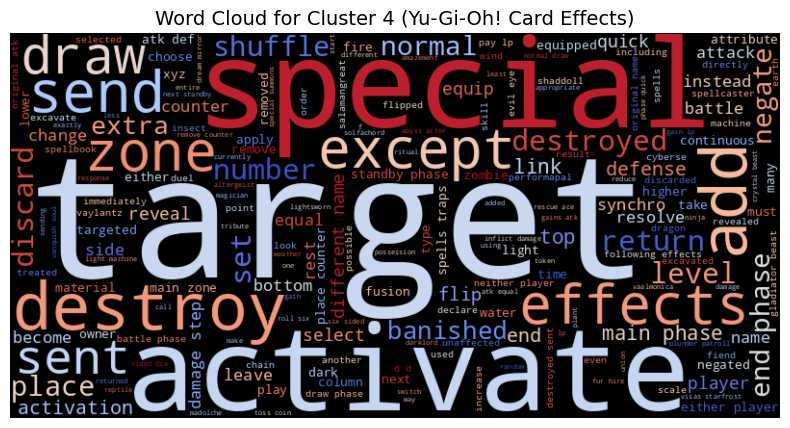

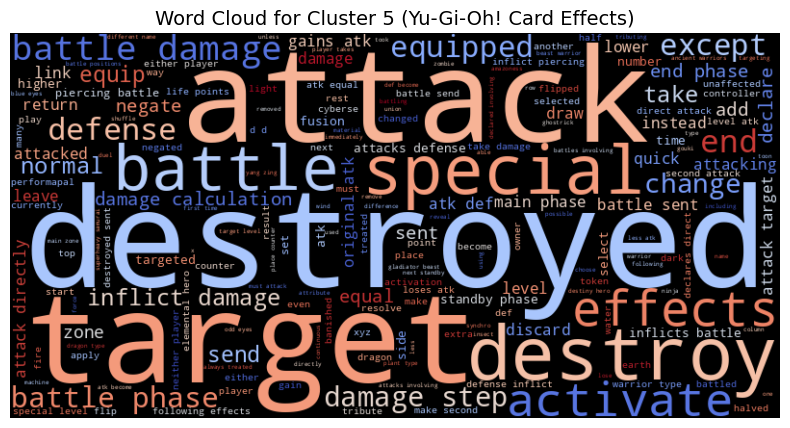

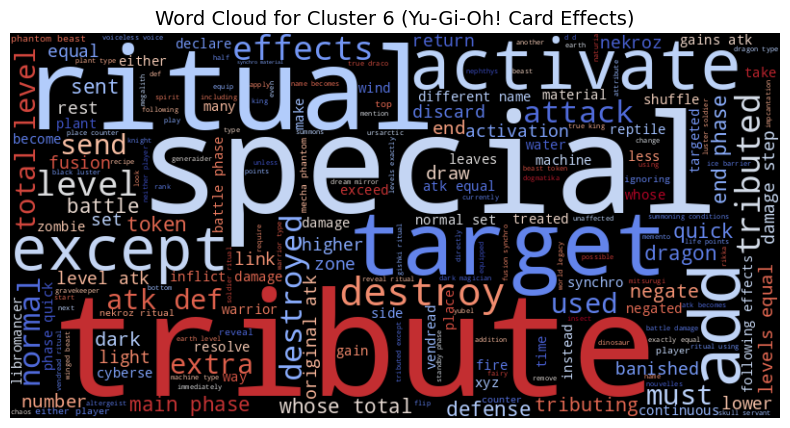

In [155]:
# Filter data for Cluster 0

for i in range(0,7):
    cluster_text = " ".join(df2[df2['cluster'] == i]['clean_desc'])
    # Generate word cloud for Cluster 0
    wordcloud = WordCloud(
        width=800, height=400, background_color='black', colormap='coolwarm',
        max_words=200, contour_color='white'
    ).generate(cluster_text)

    # Display the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")  # Hide axes
    plt.title(f"Word Cloud for Cluster {i} (Yu-Gi-Oh! Card Effects)", fontsize=14)
    plt.show()